In [1]:
# --- Imports and Setup ---
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import config
from model import TransformerAutoencoder
from explainability import analyze_anomaly_with_xai # Import the function
from data_loader import load_and_preprocess_attack_data

sns.set_style("whitegrid")

In [2]:
# --- Load Benign Data and Then the Trained Model ---
# Load data first to get the correct feature dimension.
try:
    # --- Load from the data path ---
    data_path = os.path.join('..', config.PROCESSED_DATA_DIR, 'X_benign_sequences.npy')
    X_benign_sequences = np.load(data_path)
    X_benign_tensor = torch.tensor(X_benign_sequences, dtype=torch.float32)
    
    # Dynamically get the number of features
    num_features = X_benign_sequences.shape[2]
    print(f"Benign data loaded. Shape: {X_benign_tensor.shape}. Features: {num_features}")

except FileNotFoundError:
    print("Processed data not found. Please run `src/data_loader.py` first.")
    X_benign_tensor = None
    num_features = config.INPUT_FEATURES # Fallback

# Load the model that was trained using `train.py`
if X_benign_tensor is not None:
    model = TransformerAutoencoder(
        input_features=num_features, # Use the actual feature count
        model_dim=config.MODEL_DIM,
        num_heads=config.NUM_HEADS,
        num_encoder_layers=config.NUM_ENCODER_LAYERS,
        dim_feedforward=config.DIM_FEEDFORWARD,
        dropout=config.DROPOUT
    ).to(config.DEVICE)

    try:
        model_path = os.path.join('..', config.MODEL_SAVE_PATH)
        model.load_state_dict(torch.load(model_path, map_location=config.DEVICE))
        model.eval()
        print("Trained model loaded successfully.")
    except FileNotFoundError:
        print(f"Model not found at {model_path}. Please run `python src/train.py` first.")
        model = None
else:
    model = None

Benign data loaded. Shape: torch.Size([56326, 100, 84]). Features: 84
Trained model loaded successfully.


Calculating Reconstruction Errors: 100%|██████████| 5000/5000 [00:19<00:00, 260.31it/s]


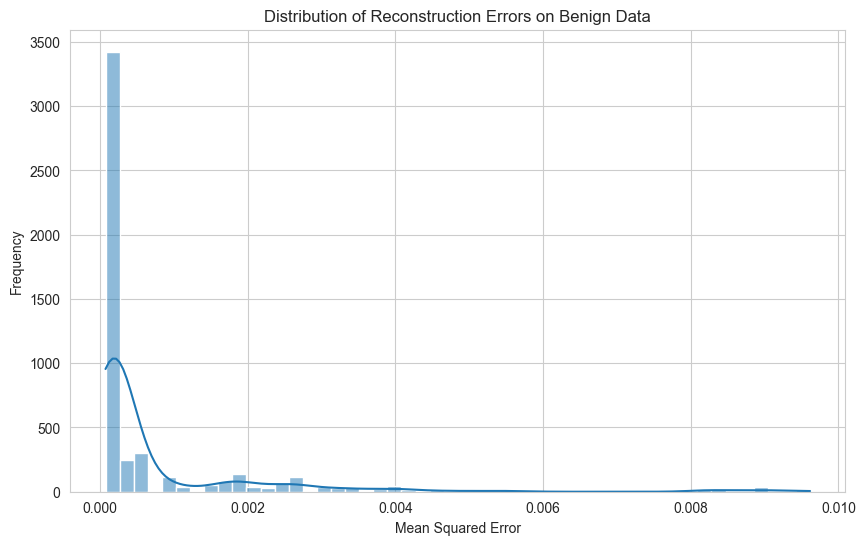

99th percentile of reconstruction errors: 0.008891
Max reconstruction error on this sample: 0.009617

A good starting threshold for anomaly detection could be around 0.008891


In [3]:
# --- Calculate and Visualize Reconstruction Errors ---
# This is crucial for setting the anomaly detection threshold.
if model and X_benign_tensor is not None:
    reconstruction_errors = []
    with torch.no_grad():
        # Iterate over a sample of the benign data to calculate errors
        for i in tqdm(range(len(X_benign_tensor[:5000])), desc="Calculating Reconstruction Errors"):
            seq = X_benign_tensor[i].unsqueeze(0).to(config.DEVICE)
            reconstruction = model(seq)
            error = nn.functional.mse_loss(reconstruction, seq).item()
            reconstruction_errors.append(error)

    # Visualize the distribution of errors
    plt.figure(figsize=(10, 6))
    sns.histplot(reconstruction_errors, bins=50, kde=True)
    plt.title('Distribution of Reconstruction Errors on Benign Data')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Frequency')
    plt.show()

    # Determine a potential threshold (e.g., 99th percentile)
    threshold = np.percentile(reconstruction_errors, 99)
    print(f"99th percentile of reconstruction errors: {threshold:.6f}")
    print(f"Max reconstruction error on this sample: {np.max(reconstruction_errors):.6f}")
    print(f"\nA good starting threshold for anomaly detection could be around {threshold:.6f}")


Simulating an anomaly by adding significant noise to a benign sequence...

Attention heatmap for the detected anomaly saved to: results/attention_heatmap.png


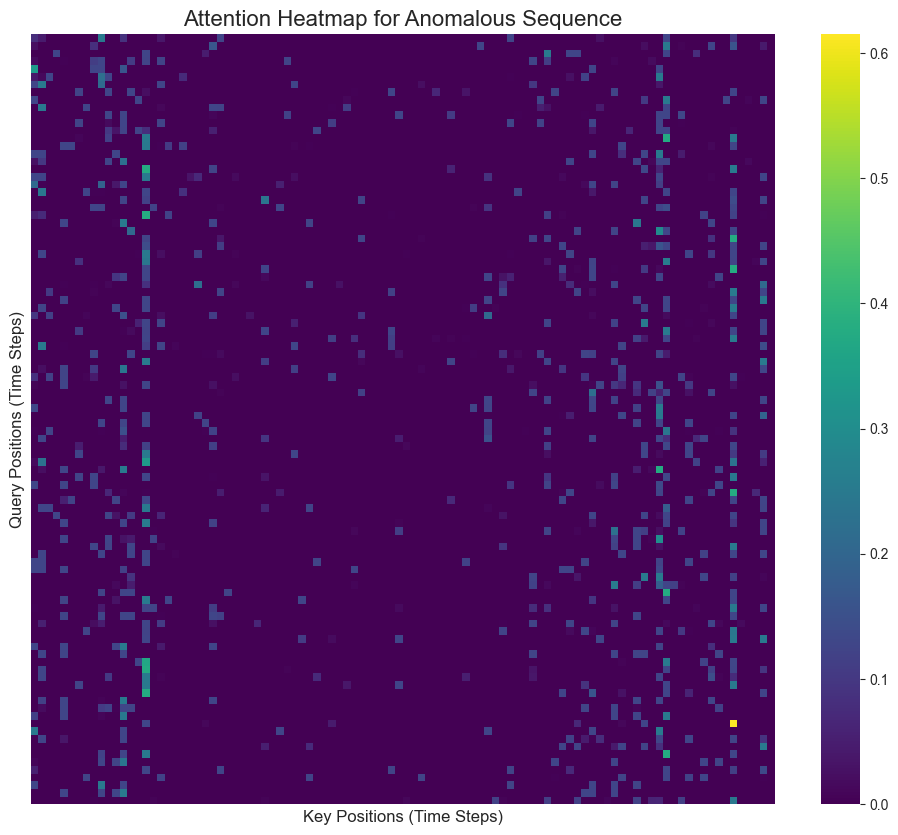

In [4]:
# --- Simulate an Anomaly and Run Explainability Module ---
# This cell creates a synthetic anomaly and uses the XAI module to visualize the attention heatmap.
if model:
    print("Simulating an anomaly by adding significant noise to a benign sequence...")
    
    # Create a noisy sequence
    if X_benign_tensor is not None:
        benign_sequence = X_benign_tensor[0].numpy()
        noise = np.random.normal(0, 0.8, size=benign_sequence.shape)
        simulated_anomaly = benign_sequence + noise
    else:
        # Fallback if data isn't loaded
        simulated_anomaly = np.random.rand(config.SEQUENCE_LENGTH, num_features)

    # The `analyze_anomaly_with_xai` function requires the model object as the first argument.
    analyze_anomaly_with_xai(model, simulated_anomaly)



--- Analyzing a Real Attack Vector ---
Loading and preprocessing data for attack type: TFTP
Attack dataset is very large (19515971 rows). Taking a random sample of 50000 rows.
Creating sequences of length 100...


100%|██████████| 49901/49901 [00:00<00:00, 4322682.50it/s]


Created 49901 sequences for 'TFTP'.
Generating attention map for a real 'TFTP' attack sequence...

Attention heatmap for the detected anomaly saved to: results/attention_heatmap.png


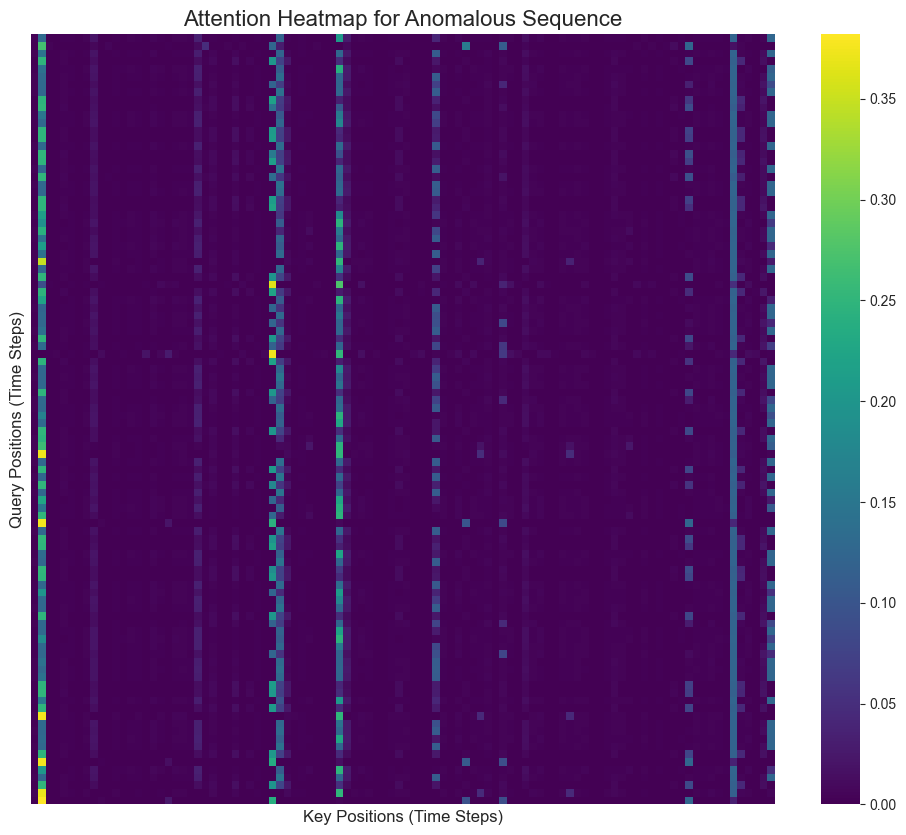

In [5]:
# --- Analyze a Real Attack Vector ---
# This cell loads data from a specific attack type and runs the XAI module on it.
if model:
    print("\n--- Analyzing a Real Attack Vector ---")
    # You can change this to any attack label from the dataset
    # e.g., 'DrDoS_SNMP', 'Syn', 'TFTP'
    attack_type_to_analyze = 'TFTP' 
    
    try:
        # Load and preprocess the attack data
        attack_sequences = load_and_preprocess_attack_data(attack_type_to_analyze)
        
        # Get the first sequence from the attack data
        real_attack_sequence = attack_sequences[0]
        
        # Run the XAI analysis
        print(f"Generating attention map for a real '{attack_type_to_analyze}' attack sequence...")
        analyze_anomaly_with_xai(model, real_attack_sequence)
        
    except (FileNotFoundError, ValueError) as e:
        print(f"Could not analyze attack data: {e}")

